In [1]:
import pdfplumber
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import re


In [2]:
PDF_PATH = "C:\Drive_d\Python\F-AI\Padala Hemanth Subbi Reddy\Input\invoice1.pdf"


In [3]:
with pdfplumber.open(PDF_PATH) as pdf:
    page = pdf.pages[0]
    chars = page.chars

len(chars)


1849

In [4]:
chars[0]


{'matrix': (1.0, 0.0, 0.0, 1.0, 553.24, 814.01),
 'fontname': 'Helvetica',
 'adv': 3.753,
 'upright': True,
 'x0': 553.24,
 'y0': 811.2155,
 'x1': 556.993,
 'y1': 824.7155,
 'width': 3.7530000000000427,
 'height': 13.5,
 'size': 13.5,
 'mcid': None,
 'tag': None,
 'object_type': 'char',
 'page_number': 1,
 'ncs': 'DeviceRGB',
 'text': ' ',
 'stroking_color': (0,),
 'non_stroking_color': (0.0, 0.0, 0.0),
 'top': 17.164499999999975,
 'bottom': 30.664499999999975,
 'doctop': 17.164499999999975}

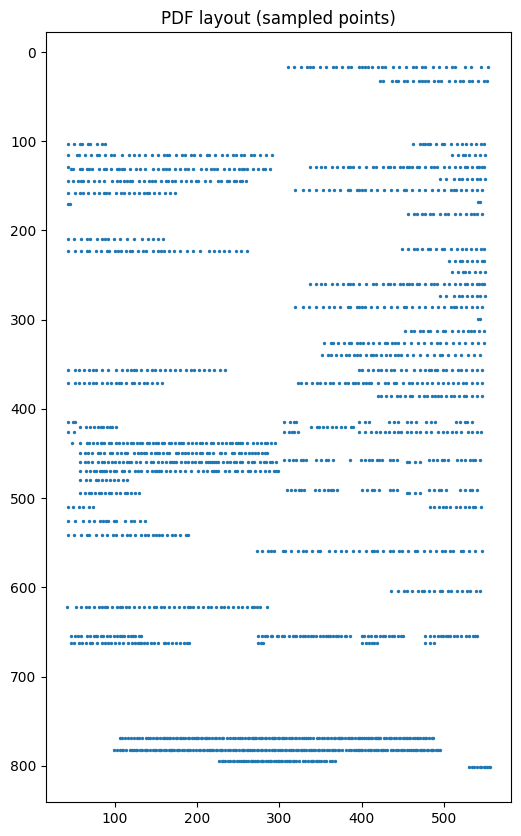

In [7]:
import random
import matplotlib.pyplot as plt

sample = random.sample(chars, min(2000, len(chars)))

plt.figure(figsize=(6, 10))

xs = [ch["x0"] for ch in sample]
ys = [ch["top"] for ch in sample]

plt.scatter(xs, ys, s=2)
plt.gca().invert_yaxis()
plt.title("PDF layout (sampled points)")
plt.show()


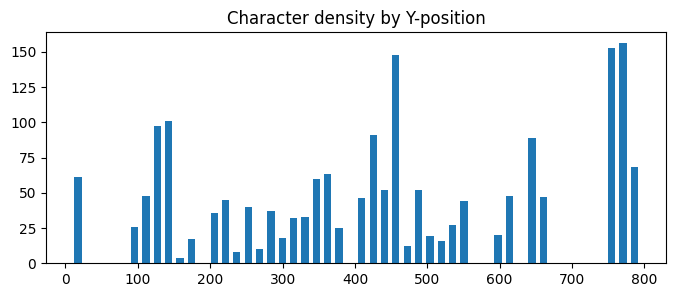

In [8]:
import numpy as np

ys = np.array([ch["top"] for ch in chars])

hist, bins = np.histogram(ys, bins=50)

plt.figure(figsize=(8, 3))
plt.bar(bins[:-1], hist, width=10)
plt.title("Character density by Y-position")
plt.show()


Detected tables: 1
Table bbox: (47.37193119775, 144.032228975625, 550.345574515875, 200.447966761125)
Total chars: 1167
Chars after table removal: 918


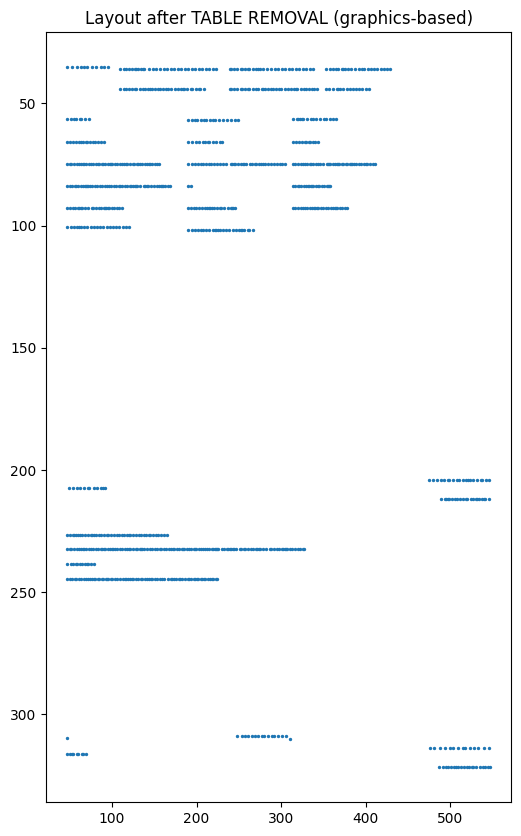

In [39]:
import pdfplumber
import matplotlib.pyplot as plt
import random

PDF_PATH = "../Input/invvoice4.pdf"
MAX_PLOT_POINTS = 2000

with pdfplumber.open(PDF_PATH) as pdf:
    page = pdf.pages[0]

    # 1. Detect tables using PDF ruling lines
    tables = page.find_tables()

    print(f"Detected tables: {len(tables)}")

    table_bboxes = []
    for t in tables:
        bbox = t.bbox  # (x0, top, x1, bottom)
        table_bboxes.append(bbox)
        print("Table bbox:", bbox)

    # 2. Extract all characters
    chars = page.chars
    print("Total chars:", len(chars))

    # 3. Remove chars inside table bounding boxes
    def inside_any_table(ch):
        for x0, top, x1, bottom in table_bboxes:
            if (x0 <= ch["x0"] <= x1) and (top <= ch["top"] <= bottom):
                return True
        return False

    filtered_chars = [ch for ch in chars if not inside_any_table(ch)]

    print("Chars after table removal:", len(filtered_chars))

# 4. SAFE visualization (points only)
sample = random.sample(
    filtered_chars,
    min(MAX_PLOT_POINTS, len(filtered_chars))
)

plt.figure(figsize=(6, 10))
plt.scatter([c["x0"] for c in sample],
            [c["top"] for c in sample],
            s=2)
plt.gca().invert_yaxis()
plt.title("Layout after TABLE REMOVAL (graphics-based)")
plt.show()

# filtered_chars is your clean input for clustering


Detected tables: 2
Table bbox: (42.11923076923077, 412.81750000000005, 553.1157142857141, 620.965)
Table bbox: (42.11923076923077, 648.985, 553.1157142857141, 674.4449999999998)
Total chars: 1849
Chars after table removal: 1186


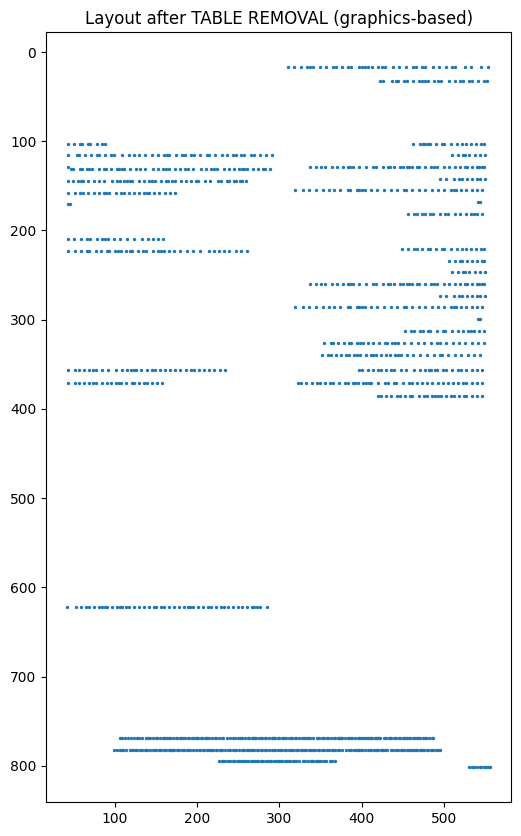

In [14]:
import pdfplumber
import matplotlib.pyplot as plt
import random

PDF_PATH = "../Input/invoice1.pdf"
MAX_PLOT_POINTS = 2000

with pdfplumber.open(PDF_PATH) as pdf:
    page = pdf.pages[0]

    # 1. Detect tables using PDF ruling lines
    tables = page.find_tables()

    print(f"Detected tables: {len(tables)}")

    table_bboxes = []
    for t in tables:
        bbox = t.bbox  # (x0, top, x1, bottom)
        table_bboxes.append(bbox)
        print("Table bbox:", bbox)

    # 2. Extract all characters
    chars = page.chars
    print("Total chars:", len(chars))

    # 3. Remove chars inside table bounding boxes
    def inside_any_table(ch):
        for x0, top, x1, bottom in table_bboxes:
            if (x0 <= ch["x0"] <= x1) and (top <= ch["top"] <= bottom):
                return True
        return False

    filtered_chars = [ch for ch in chars if not inside_any_table(ch)]

    print("Chars after table removal:", len(filtered_chars))

# 4. SAFE visualization (points only)
sample = random.sample(
    filtered_chars,
    min(MAX_PLOT_POINTS, len(filtered_chars))
)

plt.figure(figsize=(6, 10))
plt.scatter([c["x0"] for c in sample],
            [c["top"] for c in sample],
            s=2)
plt.gca().invert_yaxis()
plt.title("Layout after TABLE REMOVAL (graphics-based)")
plt.show()

# filtered_chars is your clean input for clustering


Total points: 1186
Clusters found: {0, 1, 2, 3, 4, 5, 6, -1}
Valid clusters: 7


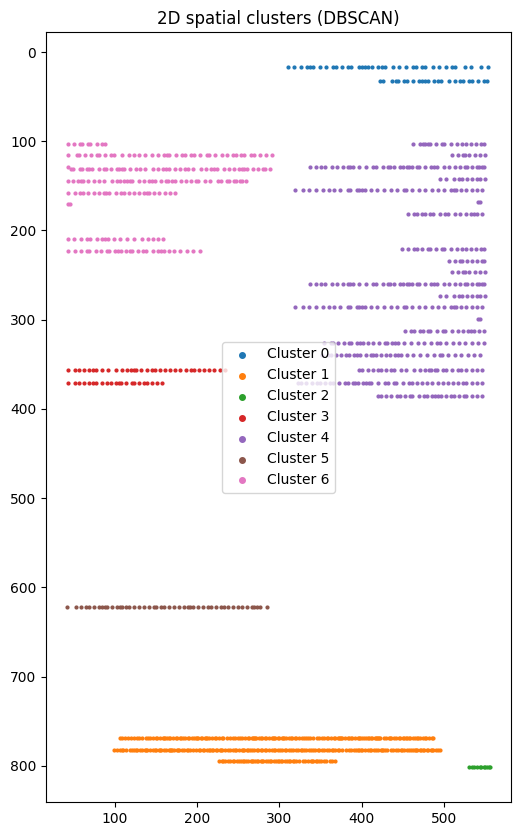

In [19]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import random

# -----------------------------
# PREPARE 2D POINTS
# -----------------------------
points = []
chars_ref = []

for ch in filtered_chars:
    x_center = (ch["x0"] + ch["x1"]) / 2
    y_center = (ch["top"] + ch["bottom"]) / 2
    points.append([x_center, y_center])
    chars_ref.append(ch)

points = np.array(points)

print("Total points:", points.shape[0])

# -----------------------------
# NORMALIZE (CRITICAL)
# -----------------------------
# X and Y scales are very different; normalize to unit space
points_norm = (points - points.mean(axis=0)) / points.std(axis=0)

# -----------------------------
# DBSCAN CLUSTERING
# -----------------------------
db = DBSCAN(
    eps=0.2,        # tune between 0.4–0.8
    min_samples=10  # tune between 20–60
)

labels = db.fit_predict(points_norm)

unique_labels = set(labels)
print("Clusters found:", unique_labels)

# -----------------------------
# GROUP CHARACTERS BY CLUSTER
# -----------------------------
clusters = {}
for label, ch in zip(labels, chars_ref):
    if label == -1:
        continue  # noise
    clusters.setdefault(label, []).append(ch)

print("Valid clusters:", len(clusters))

# -----------------------------
# SAFE VISUALIZATION
# -----------------------------
plt.figure(figsize=(6, 10))
colors = plt.cm.tab10.colors

for i, (cid, group) in enumerate(clusters.items()):
    sample = random.sample(group, min(600, len(group)))
    plt.scatter(
        [c["x0"] for c in sample],
        [c["top"] for c in sample],
        s=4,
        color=colors[i % len(colors)],
        label=f"Cluster {cid}"
    )

plt.gca().invert_yaxis()
plt.legend(markerscale=2)
plt.title("2D spatial clusters (DBSCAN)")
plt.show()

# clusters is now your TRUE layout segmentation


Total points: 918
Clusters found: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Valid clusters: 11


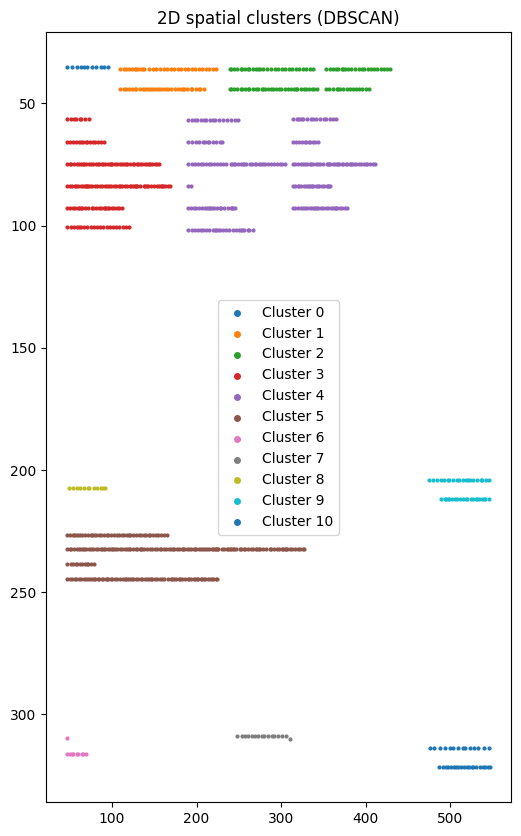

In [46]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import random

# -----------------------------
# PREPARE 2D POINTS
# -----------------------------
points = []
chars_ref = []

for ch in filtered_chars:
    x_center = (ch["x0"] + ch["x1"]) / 2
    y_center = (ch["top"] + ch["bottom"]) / 2
    points.append([x_center, y_center])
    chars_ref.append(ch)

points = np.array(points)

print("Total points:", points.shape[0])

# -----------------------------
# NORMALIZE (CRITICAL)
# -----------------------------
# X and Y scales are very different; normalize to unit space
points_norm = (points - points.mean(axis=0)) / points.std(axis=0)

# -----------------------------
# DBSCAN CLUSTERING
# -----------------------------
db = DBSCAN(
    eps=0.1,        # tune between 0.4–0.8
    min_samples=1  # tune between 20–60
)

labels = db.fit_predict(points_norm)

unique_labels = set(labels)
print("Clusters found:", unique_labels)

# -----------------------------
# GROUP CHARACTERS BY CLUSTER
# -----------------------------
clusters = {}
for label, ch in zip(labels, chars_ref):
    if label == -1:
        continue  # noise
    clusters.setdefault(label, []).append(ch)

print("Valid clusters:", len(clusters))

# -----------------------------
# SAFE VISUALIZATION
# -----------------------------
plt.figure(figsize=(6, 10))
colors = plt.cm.tab10.colors

for i, (cid, group) in enumerate(clusters.items()):
    sample = random.sample(group, min(600, len(group)))
    plt.scatter(
        [c["x0"] for c in sample],
        [c["top"] for c in sample],
        s=4,
        color=colors[i % len(colors)],
        label=f"Cluster {cid}"
    )

plt.gca().invert_yaxis()
plt.legend(markerscale=2)
plt.title("2D spatial clusters (DBSCAN)")
plt.show()

# clusters is now your TRUE layout segmentation


In [20]:
def cluster_to_text(chars, y_tol=3):
    """
    Convert clustered characters into readable text
    """
    chars = sorted(chars, key=lambda c: (c["top"], c["x0"]))

    lines = []
    current = ""
    last_top = None

    for ch in chars:
        if last_top is None or abs(ch["top"] - last_top) < y_tol:
            current += ch["text"]
        else:
            lines.append(current.strip())
            current = ch["text"]
        last_top = ch["top"]

    if current:
        lines.append(current.strip())

    return "\n".join(lines)


cluster_texts = {
    cid: cluster_to_text(group)
    for cid, group in clusters.items()
}


In [21]:
for cid, text in sorted(cluster_texts.items()):
    print(f"\n===== CLUSTER {cid} =====")
    print(text[:1200])



===== CLUSTER 0 =====
Tax Invoice/Bill of Supply/Cash Memo
(Original for Recipient)

===== CLUSTER 1 =====
*ASSPL-Amazon Seller Services Pvt. Ltd., ARIPL-Amazon Retail India Pvt. Ltd. (only where Amazon Retail India Pvt. Ltd. fulfillment center is co-located)
Customers desirous of availing input GST credit are requested to create a Business account and purchase on Amazon.in/business from Business eligible offers
Please note that this invoice is not a demand for payment

===== CLUSTER 2 =====
Page 1 of 1

===== CLUSTER 3 =====
Order Number: 407-5197552-2567522
Order Date: 31.03.2025

===== CLUSTER 4 =====
Billing Address :
Shivangi
Narmada, SRM University AP, Mangalagiri,
Amaravathi
MANGALAGIRI, ANDHRA PRADESH, 522502
IN
State/UT Code: 37
Shipping Address :
Shivangi
Shivangi
Narmada, SRM University AP, Mangalagiri,
Amaravathi
MANGALAGIRI, ANDHRA PRADESH, 522502
IN
State/UT Code: 37
Place of supply: ANDHRA PRADESH
Place of delivery: ANDHRA PRADESH
Invoice Number : XIPB-51163
Invoice Det

In [23]:
seller_text = ""
billing_text = ""
shipping_text = ""
metadata_text = ""
footer_text = ""
reverse_charge_text = ""
invoice_type = ""


In [24]:
for cid, text in cluster_texts.items():
    t = text.lower()

    # Invoice type
    if "tax invoice" in t or "bill of supply" in t:
        invoice_type = text

    # Seller block
    if "sold by" in t:
        seller_text += "\n" + text

    # Order / invoice metadata
    if "order number" in t or "invoice number" in t:
        metadata_text += "\n" + text

    # Billing + Shipping live together (for now)
    if "billing address" in t or "shipping address" in t:
        metadata_text += "\n" + text

    # Reverse charge
    if "reverse charge" in t:
        reverse_charge_text += "\n" + text

    # Footer (amounts / words)
    if "amount in words" in t or "total" in t:
        footer_text += "\n" + text


In [25]:
print("=== SELLER TEXT ===\n", seller_text)
print("\n=== METADATA TEXT ===\n", metadata_text[:1500])
print("\n=== FOOTER TEXT ===\n", footer_text)
print("\n=== REVERSE CHARGE TEXT ===\n", reverse_charge_text)


=== SELLER TEXT ===
 
Sold By :
WISELIFE WELLNESS INDIA PRIVATE LIMITED
* Plot No 03 , Basement Behrampur Road , Sector
34, Landmark : Near Axis Bank ATM District
Gurgaon, Haryana, 122004
IN
PAN No: AADCW2090C
GST Registration No: 06AADCW

=== METADATA TEXT ===
 
Order Number: 407-5197552-2567522
Order Date: 31.03.2025
Billing Address :
Shivangi
Narmada, SRM University AP, Mangalagiri,
Amaravathi
MANGALAGIRI, ANDHRA PRADESH, 522502
IN
State/UT Code: 37
Shipping Address :
Shivangi
Shivangi
Narmada, SRM University AP, Mangalagiri,
Amaravathi
MANGALAGIRI, ANDHRA PRADESH, 522502
IN
State/UT Code: 37
Place of supply: ANDHRA PRADESH
Place of delivery: ANDHRA PRADESH
Invoice Number : XIPB-51163
Invoice Details : HR-XIPB-2132621725-2425
Invoice Date : 31.03.2025
Billing Address :
Shivangi
Narmada, SRM University AP, Mangalagiri,
Amaravathi
MANGALAGIRI, ANDHRA PRADESH, 522502
IN
State/UT Code: 37
Shipping Address :
Shivangi
Shivangi
Narmada, SRM University AP, Mangalagiri,
Amaravathi
MANGALAGIR

In [26]:
import re

def extract_block(text, start_pattern, end_patterns):
    start = re.search(start_pattern, text, re.IGNORECASE)
    if not start:
        return ""

    sub = text[start.end():]

    end_positions = []
    for pat in end_patterns:
        m = re.search(pat, sub, re.IGNORECASE)
        if m:
            end_positions.append(m.start())

    if end_positions:
        sub = sub[:min(end_positions)]

    return sub.strip()


In [27]:
billing_text = extract_block(
    metadata_text,
    start_pattern=r"Billing Address\s*:?",
    end_patterns=[
        r"Shipping Address",
        r"Invoice Number",
        r"Order Number"
    ]
)

shipping_text = extract_block(
    metadata_text,
    start_pattern=r"Shipping Address\s*:?",
    end_patterns=[
        r"Billing Address",
        r"Invoice Number",
        r"Order Number"
    ]
)


In [28]:
print("=== BILLING ===\n", billing_text)
print("\n=== SHIPPING ===\n", shipping_text)


=== BILLING ===
 Shivangi
Narmada, SRM University AP, Mangalagiri,
Amaravathi
MANGALAGIRI, ANDHRA PRADESH, 522502
IN
State/UT Code: 37

=== SHIPPING ===
 Shivangi
Shivangi
Narmada, SRM University AP, Mangalagiri,
Amaravathi
MANGALAGIRI, ANDHRA PRADESH, 522502
IN
State/UT Code: 37
Place of supply: ANDHRA PRADESH
Place of delivery: ANDHRA PRADESH


In [29]:
import pdfplumber
import re

def clean_amount(val):
    if not val:
        return ""
    return (
        val.replace("₹", "")
           .replace(",", "")
           .strip()
    )

def extract_table_fields(pdf_path):
    total_amount = ""
    total_tax = ""
    amount_in_words = ""

    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            tables = page.extract_tables()

            for table in tables:
                for r, row in enumerate(table):
                    # Join row safely
                    joined = " ".join(cell or "" for cell in row).lower()

                    # -------------------------------
                    # TOTAL AMOUNT (Amazon + Flipkart)
                    # -------------------------------
                    if (
                        "total:" in joined
                        or "total price" in joined
                        or "invoice value" in joined
                    ):
                        for cell in row:
                            if cell and re.search(r"\d", cell):
                                total_amount = clean_amount(cell)

                    # -------------------------------
                    # TOTAL TAX (IGST / CGST / SGST)
                    # -------------------------------
                    if (
                        "igst" in joined
                        or "cgst" in joined
                        or "sgst" in joined
                        or "tax" in joined
                    ):
                        for cell in row:
                            if cell and re.search(r"\d", cell):
                                total_tax = clean_amount(cell)

                    # -------------------------------
                    # AMOUNT IN WORDS (row-contained)
                    # -------------------------------
                    for cell in row:
                        if cell and "amount in words" in cell.lower():
                            amount_in_words = (
                                cell.split(":", 1)[-1].strip()
                            )

                    # -------------------------------
                    # AMOUNT IN WORDS (next-row spill)
                    # -------------------------------
                    if not amount_in_words and "amount in words" in joined:
                        if r + 1 < len(table):
                            next_row = table[r + 1]
                            amount_in_words = " ".join(
                                cell for cell in next_row if cell
                            ).strip()

    return {
        "total_amount": total_amount,
        "total_tax": total_tax,
        "amount_in_words": amount_in_words
    }


In [30]:
amazon_pdf = r"C:\Drive_d\Python\F-AI\Padala Hemanth Subbi Reddy\Input\invoice1.pdf"
flipkart_pdf = r"C:\Drive_d\Python\F-AI\Padala Hemanth Subbi Reddy\Input\invvoice4.pdf"

print("AMAZON TABLE DATA")
print(extract_table_fields(amazon_pdf))

print("\nFLIPKART TABLE DATA")
print(extract_table_fields(flipkart_pdf))


AMAZON TABLE DATA
{'total_amount': 'Invoice Value:\n245.00', 'total_tax': '245.00\n0.00', 'amount_in_words': 'Two Hundred Forty-five only'}

FLIPKART TABLE DATA
{'total_amount': '', 'total_tax': 'SPL Back Cover for Realme 8 Black MSVII\\RLM8\nHSN: 39269099 | IGST: 18% 1 299.00 -15.00 240.68 43.32 284.00\n| MSVII//REALME8\\\\BLACK | IMEI/SrNo: [[]]\nShipping and Handling\n1 0.00 0 0.00 0.00 0.00\nCharges', 'amount_in_words': ''}


In [34]:
import pdfplumber
import pandas as pd

PDF_PATH = r"C:\Drive_d\Python\F-AI\Padala Hemanth Subbi Reddy\Input\invoice2.pdf"


In [35]:
tables_dfs = []

with pdfplumber.open(PDF_PATH) as pdf:
    for page_no, page in enumerate(pdf.pages):
        tables = page.extract_tables()
        
        for t_idx, table in enumerate(tables):
            # Convert raw table to DataFrame
            df = pd.DataFrame(table)
            df["__page__"] = page_no
            df["__table__"] = t_idx
            tables_dfs.append(df)

len(tables_dfs)


1

In [36]:
for i, df in enumerate(tables_dfs):
    print(f"\n===== TABLE {i} =====")
    display(df)



===== TABLE 0 =====


,0,1,2,3,4,5,6,7,8,9,__page__,__table__
0,Sl.\nNo,Description,Unit\nPrice,Discount,Qty,Net\nAmount,Tax\nRate,Tax\nType,Tax\nAmount,Total\nAmount,0,0
1,1,"Haldiram's Bhujia, 1kg | B06WWKR6BS ( B06WWKR6...",₹250.00\n₹35.71,-₹12.50\n-₹35.71,1,₹237.50\n₹0.00,12%\n12%,IGST\nIGST,₹28.50\n₹0.00,₹266.00\n₹0.00,0,0
2,2,Geki Hot & Spicy Korean Instant Noodles Chicke...,₹200.89\n₹35.71,-₹10.04\n-₹35.71,1,₹190.85\n₹0.00,12%\n12%,IGST\nIGST,₹22.90\n₹0.00,₹213.75\n₹0.00,0,0
3,3,"Saffola Masala Oats Karara Crunch, Tasty Eveni...",₹189.52\n₹38.10,-₹9.48\n-₹38.10,1,₹180.04\n₹0.00,5%\n5%,IGST\nIGST,₹9.01\n₹0.00,₹189.05\n₹0.00,0,0
4,TOTAL:,None,None,None,None,None,None,None,₹60.41,₹668.80,0,0
5,Amount in Words:\nSix Hundred Sixty-eight Poin...,None,None,None,None,None,None,None,None,None,0,0
6,For Amazon Retail India Private Limited:\nAuth...,None,None,None,None,None,None,None,None,None,0,0


In [54]:
import pdfplumber
import pandas as pd
import re

PDF_PATH = r"C:\Drive_d\Python\F-AI\Padala Hemanth Subbi Reddy\Input\invvoice4.pdf"

# -------------------------------
# 1. Extract raw table text
# -------------------------------
with pdfplumber.open(PDF_PATH) as pdf:
    page = pdf.pages[0]
    raw_table = page.extract_tables()[0]

lines = []
for row in raw_table:
    for cell in row:
        if cell:
            lines.extend(cell.split("\n"))

lines = [l.strip() for l in lines if l.strip()]

# -------------------------------
# 2. Build logical rows
# -------------------------------
rows = []
current_desc = []

for line in lines:
    # Line with many numbers = data line
    numbers = re.findall(r"\d+\.\d+|\d+", line)

    if len(numbers) >= 5:
        rows.append({
            "description": " ".join(current_desc),
            "numeric": line
        })
        current_desc = []
    else:
        # description / continuation
        current_desc.append(line)

# -------------------------------
# 3. Parse numeric columns
# -------------------------------
final_rows = []

for r in rows:
    nums = re.findall(r"\d+\.\d+|\d+", r["numeric"])

    if len(nums) < 6:
        continue

    final_rows.append({
        "Product Description": r["description"],
        "Qty": nums[0],
        "Gross Amount": nums[1],
        "Discount": nums[2],
        "Taxable Value": nums[3],
        "IGST": nums[4],
        "Total": nums[5]
    })

# -------------------------------
# 4. Create DataFrame
# -------------------------------
flipkart_df = pd.DataFrame(final_rows)

flipkart_df


,Product Description,Qty,Gross Amount,Discount,Taxable Value,IGST,Total
0,Gross Taxable Product Description Qty Discount...,39269099,18,1,299.00,15.00,240.68
1,| MSVII//REALME8\\BLACK | IMEI/SrNo: [[]] Ship...,1,0.00,0,0.00,0.00,0.00
